## Bayesian Inference

Before, we saw how to use `scipy.optimize` to calculate maximum likelihood estimates of the parameters to a skew normal distribution describing nanoparticle sizes.

Here we'll do something similar, but using Bayesian parameter inference techniques. Remember that Bayesian inference describe parameters with a **probability distribution** instead of an estimate value. This probability distribution represent our uncertainty about the parameter in question. 

Recall the mneumonic

Posterior = Likelihood x Prior

Here the Prior distribution represents our initial beliefs about the parameter(s) in question. It's obtained externally from the data. The likelihood compute the probability (or probability density) of the data given parameter values. The Posterior describes the belief on parameters after observing the data.


To start, let's import the standard libraries we've been using.


In [2]:
from scipy import stats, optimize
import numpy as np
import matplotlib.pyplot as plt

Next we'll import the NP radius observations. We'll also recall the ML estimates for the parameters we obtained last time.

In [ ]:
R = np.loadtxt('np_radii.txt')

alpha_MLE = -5.74661014297758
mu_MLE = 1.3090052746628307
sigma_MLE = 0.25743751644792884

To keep things simple, we'll assume both $\alpha$ and $\sigma$ parameters are fixed (and fixed to their ML estimates), and we'll perform our Bayesian analysis on a single parameter $\mu$. That is, we'll try to define a probability distirbution of what $\mu$ can be. 

Let's define the likelihood function, since we'll need it to compute the posteriors.

In [ ]:
# Likelihood for the Skew Normal distribution with fixed alpha and sigma.
# This is slightly different from last time. Here, we'll allow users to pass
# in a whole array of mu values, of each we will calculate the likelihood
# value L(mu).
def likelihood(mu_arr, R):
    # We'll keep alpha and sigma fixed
    alpha = alpha_MLE
    sigma = sigma_MLE
    
    # the array of likelihood values we will return. One likelihood for each 
    # mu value in mu_arr.
    ret_val = np.zeros(len(mu_arr))
        
    # iterate over the different mu values
    for i in range(len(mu_arr)):
        mu = mu_arr[i]
    
        # evaluate the skew norm pdf for each element in R
        # using the stats.skewnorm.pdf(data, alpha, mu, sigma) function
        pdf_vals = stats.skewnorm.pdf(R, alpha, mu, sigma)
    
        # calculate likelihood componentwise
        ret_val[i] = np.prod(pdf_vals)
    
    # return the likelihood
    return ret_val

Now we'll define our data set. To illustrate the Bayesian method, we'll 

1. Consider a small subset of our data (only 5 points) and
2. Include an outlier.

In [ ]:
# We'll alter some data values, so let's copy R to keep the original values untouched
R_copy = np.copy(R[0:100])

# put in an outlier
print("Original value of R_copy[0] = " + str(R_copy[0]))
R_copy[0] = 1.5*R_copy[0]
print("New value of R_copy[0] = " + str(R_copy[0]))

Now we'll calculate some likelihoods for several values of the parameter $\mu$, and while we're at it, let's find the maximum likelihood estimate.

In [ ]:
# define the set of mu we'll compute on
mu_arr = np.linspace(0, 2, 1000)

# Calculate the likelihood of each value of mu based on the first 5 data points
likelihood_mu = likelihood(mu_arr, R_copy)

# let's "optimize" by just finding the largest likelihood value 
# This is different from last lecture, where we used scipy.optimize.minimize

# the index of the maximum likelihood  
i_max = np.argmax(likelihood_mu)

# the corresponding mu value that lead to maximum likelihood
mu_MLE_with_outlier = mu_arr[i_max]

print("ML estimate of mu using 5 data points containing 1 outlier: mu = " + str(mu_MLE_with_outlier))
print("True ML estimate: mu = " + str(mu_MLE))

Here we see that the combination of a small data set and a single outlier caused the ML estimate to change.

Here's a plot to visualize the likelihood values.

In [ ]:
# Let's plot the likelihood function
plt.plot(mu_arr, likelihood_mu)
plt.xlabel('mu')
plt.ylabel('L(mu)')

# Let's indicate the true value as well
plt.axvline(x=mu_MLE, color='red')

The perturbation to the data means that the true value of $mu$ gets a really low likelihood score.

Now let's try to do the Bayesian inference. Recall to do this, we need a prior distirbution on $mu$. Suppose you read an article to suggest the mean NP size was $1 \pm 0.05$. This isn't quite exactly what you want (since mean particle size and the $\mu$ parameter to a skew normal distribution are different things, but are close when there isn't much skew in the distribution). But it's a start. So let's use that.


In [ ]:
# prior distribution on mu ~ N(1, 0.05^2)
prior_mean = 1
prior_std = 0.05
prior = stats.norm.pdf(mu_arr, prior_mean, prior_std)

# plot the prior distribution
plt.plot(mu_arr, prior)
plt.xlabel('mu')
plt.ylabel('Prior')
plt.title('Prior distribution')


Note that
1. The mean estimate of $\mu = 1$ is pretty bad (compared to the true value of 1.3, and the 1.5 value obtained in small data including outlier case).
2. To make things worse, the value of $0.05$ is relatively small - suggesting a high degree of confidence in our prior.

What does the including the data (calculating the posterior) do to fix things?

In [ ]:
# posterior distribution is proportional to likelihood * prior
posterior = likelihood_mu*prior

# plot the posterior distribution (unnormalized)
plt.plot(mu_arr, posterior)
plt.xlabel('mu')
plt.ylabel('Posterior')
plt.title('Posterior distribution (unnormalized)')

# Let's indicate the true value as well
plt.axvline(x=mu_MLE, color='red')

In [ ]:
# Let's summarize the posterior distribution

# N.B. We can't use np.mean, np.variance. These work on data samples. Here we have pdf values, so we'll 
# calculate using definitions

# quick-and-dirty normalization - numerically calculate the area over the domain and divide it out
# so that we have an area of 1 over domain
dx = mu_arr[1] - mu_arr[0]
area = np.sum(posterior*dx)
posterior_normalized = posterior/area

# mean
mean_mu_posterior = np.sum(mu_arr*posterior_normalized*dx)
print("posterior mean = " + str(mean_mu_posterior))

# variance
var_mu_posterior = np.sum((mu_arr- mean_mu_posterior)**2*posterior_normalized*dx)
print("posterior variance = " + str(var_mu_posterior))

# std
print("posterior std = " + str(np.sqrt(var_mu_posterior)))

The posterior mean of $\mu$ is very close to the true value. Note that our posterior uncertainty went down too (compare std values between prior and posterior). To be fair, this was a coincidence to some degree. To see this, play around with different prior distributions. In particular, consider prior means less-than, equal-to, and greater-than the ML estimate.

While the posterior may look Normal, it's important to realize it isn't. To test this, we can estimate the **skewness** summary statistic:

$$Skew(X) = \mathbb E[(X - \bar X)^3].$$

A normal distribution has 0 skew - it is symmetric about its mean. 

In [ ]:
# skewness
skew_mu_posterior = np.sum((mu_arr - mean_mu_posterior)**3*posterior_normalized*dx)
print("Posterior skew = " + str(np.cbrt(skew_mu_posterior)))

# skewness of prior
skew_mu_prior = np.sum((mu_arr - 1)**3*prior*dx)
print("Prior skew = " + str(np.cbrt(skew_mu_prior)))

What can you say about the skewness of the posterior vs. the prior (which is a true Normal distribution)?


### Further experiments:

How does the mean estimate of the posterior (aka the MAP estimator) change as you increase the amount of data?

## Hypothesis Testing




(array([ 1.,  1.,  5.,  7., 60., 95., 38., 25.,  5.,  3.]),
 array([345.294, 392.93 , 440.566, 488.202, 535.838, 583.474, 631.11 ,
        678.746, 726.382, 774.018, 821.654]),
 <a list of 10 Patch objects>)

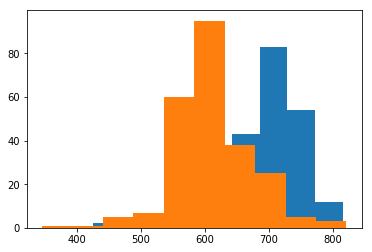

In [3]:
data = np.loadtxt('JAHANMI2.txt', skiprows=1)
Y = data[:, 4]
B = data[:,13]
I_B1 = (B==1)
Y_given_B1 = Y[I_B1]
I_B2 = (B==2)
Y_given_B2 = Y[I_B2]

# plot histograms of both
plt.hist(Y_given_B1)
plt.hist(Y_given_B2)

### F-test to compare sample variances between two populations.

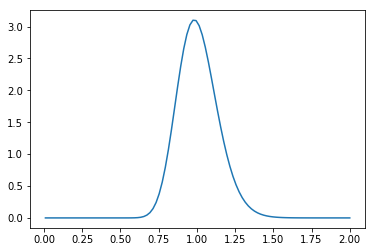

In [4]:
t = np.linspace(0.01, 2, 100)

# Degrees of freedom = # data points - 1
nu_1 = len(Y_given_B1) - 1
nu_2 = len(Y_given_B2) - 1

y = stats.f.pdf(t, nu_1, nu_2)
plt.plot(t, y)

In [6]:
var1 = np.var(Y_given_B1)
var2 = np.var(Y_given_B2)

# Tests if two variances are the same: F-test
T = var1/var2

# calculate p value (one-sided right tail)
p_value = 1 - stats.f.cdf(T, nu_1, nu_2)

print(p_value)

# Reject or retain null hypothesis
if(p_value < 0.05):
    print("Null hypothesis rejected. Sample variances are statistically different")
else:
    print("Null hypothesis retained. Sample variances are not statistically different")



0.18519146513473972
Null hypothesis retained. Sample variances are not statistically different


### t-test to compare sample means between two populations.


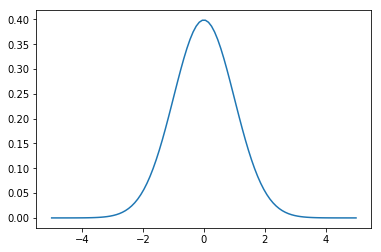

In [7]:
# Tests if two means are the same: t-test

# plot the t-distribution
mu1 = np.mean(Y_given_B1)
mu2 = np.mean(Y_given_B2)

n1 = len(Y_given_B1)
n2 = len(Y_given_B2)

nu = n1 + n2 - 2

t = np.linspace(-5, 5, 100)
y = stats.t.pdf(t, nu)
plt.plot(t, y)

In [10]:
# Tests if two means are the same: t-test

T = (mu1 - mu2)/np.sqrt(var1/n1 + var2/n2)

# two-sided test
p_value = 1 - stats.t.cdf(T, nu) + stats.t.cdf(-T, nu)

print(p_value)

# Reject or retain null hypothesis
if(p_value < 0.05):
    print("Null hypothesis rejected. Sample means are statistically different")
else:
    print("Null hypothesis retained. Sample means are not statistically different")


2.5166154703799334e-35
Null hypothesis rejected. Sample means are statistically different
